# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 30
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews
Scraping page 21
   ---> 2100 total reviews
Scraping page 22
   ---> 2200 total reviews
Scraping page 23
   ---> 2300 total reviews
Scrapi

In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df

,reviews
0,✅ Trip Verified | Late boarding led to a one ...
1,✅ Trip Verified | As usual the flight is delay...
2,✅ Trip Verified | I had the most fantastic BA...
3,✅ Trip Verified | Couldn’t book in online. Ar...
4,✅ Trip Verified | London Heathrow to Mumbai in...
...,...
2995,We flew from LHR to Brussels and back on a rew...
2996,GRU-LHR 15 March 2015. Returned to BA this las...
2997,GVA-LGW-GVA A319 out and A320 in. On time in b...
2998,I have been a longstanding BA gold card holder...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  3000 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB


In [5]:
import os
if not os.path.exists('data'):
    os.makedirs('data')

In [6]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [7]:
#import relevant libraries
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim import corpora, models
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [8]:
# Remove duplicates based on 'reviews' column, keeping the first occurrence
df.drop_duplicates(subset=['reviews'], keep='first', inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Data cleaning functions
def clean_text(text):
    text = re.sub(r'^(✅ )?(Trip Verified|Verified Review|Not Verified) \|', '', text, flags=re.IGNORECASE)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df['cleaned_reviews'] = df['reviews'].apply(clean_text)

In [9]:
# Sentiment analysis using VADER
sid = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['cleaned_reviews'].apply(lambda x: sid.polarity_scores(x))
df['sentiment_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

In [10]:
from gensim import corpora, models

# Tokenize the cleaned reviews
tokenized_reviews = [review.split() for review in df['cleaned_reviews']]

# Create a dictionary and a corpus
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_reviews]

# Build the LDA model
num_topics = 5  # We can adjust the number of topics
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

# Get the topic distribution for each document
topic_distributions = [lda_model[doc] for doc in corpus]

# Assign the most dominant topic to each document
dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in topic_distributions]

# Map topic numbers to topic labels (We can customize these labels)
topic_labels = {0: 'Travel Experience', 1: 'Customer Service', 2: 'Flight Booking', 3: 'In-Flight Experience', 4: 'Airport Experience'}

# Create a 'topic' column in the DataFrame
df['topic'] = [topic_labels[topic] for topic in dominant_topics]

In [11]:
# Word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(df['cleaned_reviews']))

In [12]:
# Display sentiment
print("Sentiment Analysis:")
print(df[['reviews', 'cleaned_reviews', 'sentiment_score', 'sentiment']])

Sentiment Analysis:
                                                reviews  \
0     ✅ Trip Verified |  Late boarding led to a one ...   
1     ✅ Trip Verified | As usual the flight is delay...   
2     ✅ Trip Verified |  I had the most fantastic BA...   
3     ✅ Trip Verified |  Couldn’t book in online. Ar...   
4     ✅ Trip Verified | London Heathrow to Mumbai in...   
...                                                 ...   
2992  We flew from LHR to Brussels and back on a rew...   
2993  GRU-LHR 15 March 2015. Returned to BA this las...   
2994  GVA-LGW-GVA A319 out and A320 in. On time in b...   
2995  I have been a longstanding BA gold card holder...   
2996  Having heard so many negative reviews of BA I ...   

                                        cleaned_reviews  sentiment_score  \
0     late boarding led hour flight leaving hour lat...          -0.5994   
1     usual flight delayed ba try blame inability in...          -0.7579   
2     fantastic ba flight today cabin crew 

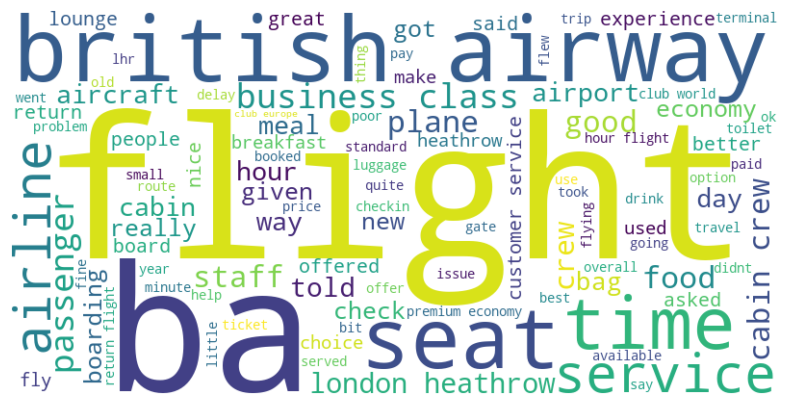

In [13]:
#Display wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# Sentiment Distribution in percentage
sentiment_counts_ratio = df['sentiment'].value_counts(normalize=True)*100
sentiment_counts_ratio

positive    64.698031
negative    34.801468
neutral      0.500501
Name: sentiment, dtype: float64

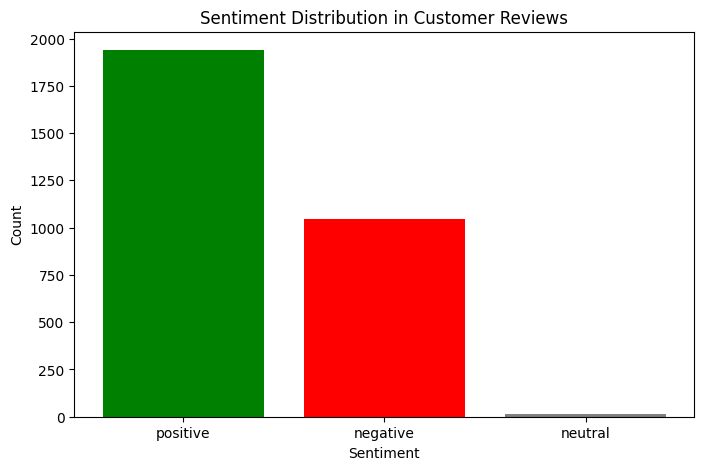

In [15]:
# Sentiment Distribution
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'gray'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Customer Reviews')
plt.show()


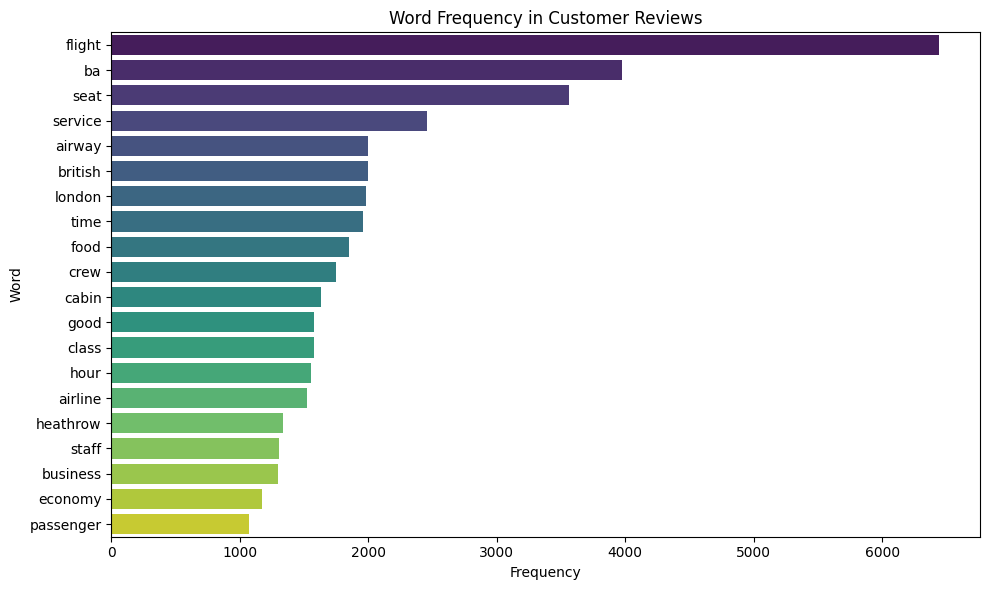

In [16]:
# Word Frequency Bar Plot
import seaborn as sns
word_freq = df['cleaned_reviews'].str.split(expand=True).stack().value_counts()
top_word_freq = word_freq[:20]  # Adjust the number of top words to show
plt.figure(figsize=(10, 6))
sns.barplot(x=top_word_freq.values, y=top_word_freq.index, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Word Frequency in Customer Reviews')
plt.tight_layout()
plt.show()

In [28]:
top_word_freq

flight       6440
ba           3974
seat         3564
service      2458
airway       2001
british      1998
london       1984
time         1958
food         1846
crew         1752
cabin        1629
good         1581
class        1580
hour         1550
airline      1522
heathrow     1332
staff        1303
business     1300
economy      1174
passenger    1069
dtype: int64

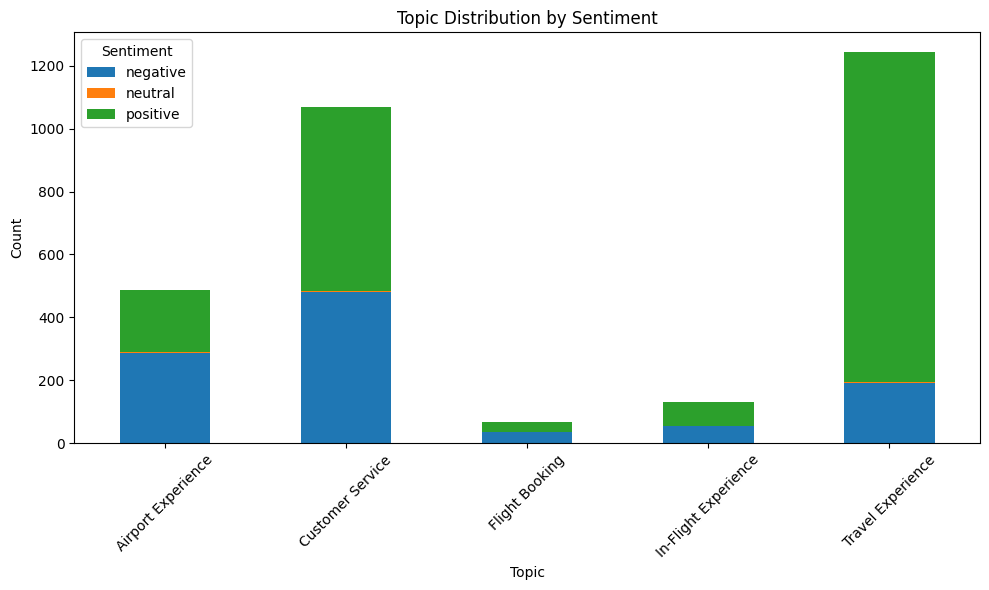

In [18]:
#Topic Distribution Bar Plot
topic_sentiment_counts = df.groupby(['topic', 'sentiment']).size().unstack()
topic_sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Topic Distribution by Sentiment')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


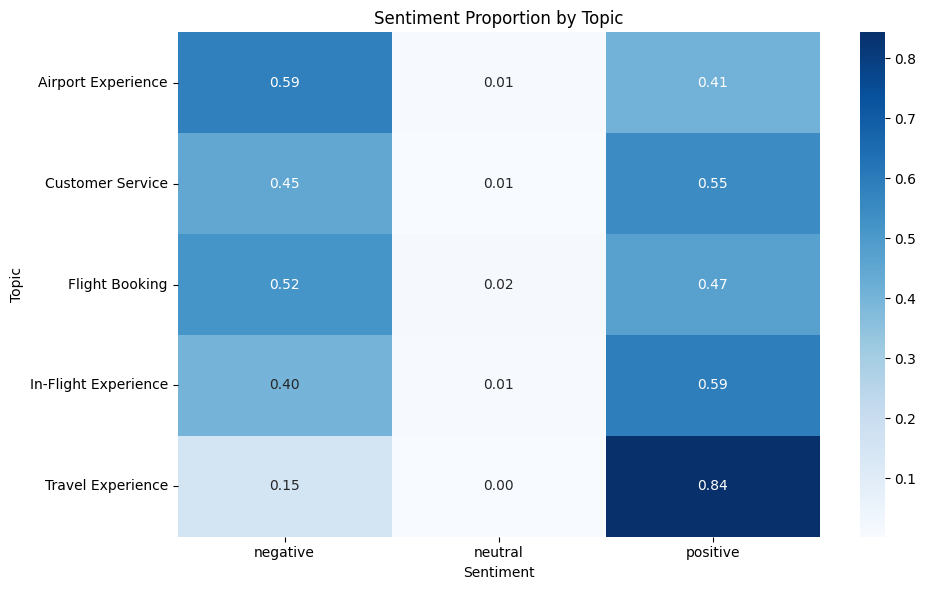

In [19]:
#Sentiment Heatmap (Sentiment by Topic)
topic_sentiment_heatmap = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)
plt.figure(figsize=(10, 6))
sns.heatmap(topic_sentiment_heatmap, cmap='Blues', annot=True, fmt=".2f")
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.title('Sentiment Proportion by Topic')
plt.tight_layout()
plt.show()


In [29]:
topic_sentiment_heatmap

sentiment,negative,neutral,positive
topic,,,
Airport Experience,0.585216,0.008214,0.406571
Customer Service,0.448502,0.005618,0.545880
Flight Booking,0.515152,0.015152,0.469697
In-Flight Experience,0.401515,0.007576,0.590909
Travel Experience,0.154341,0.002412,0.843248


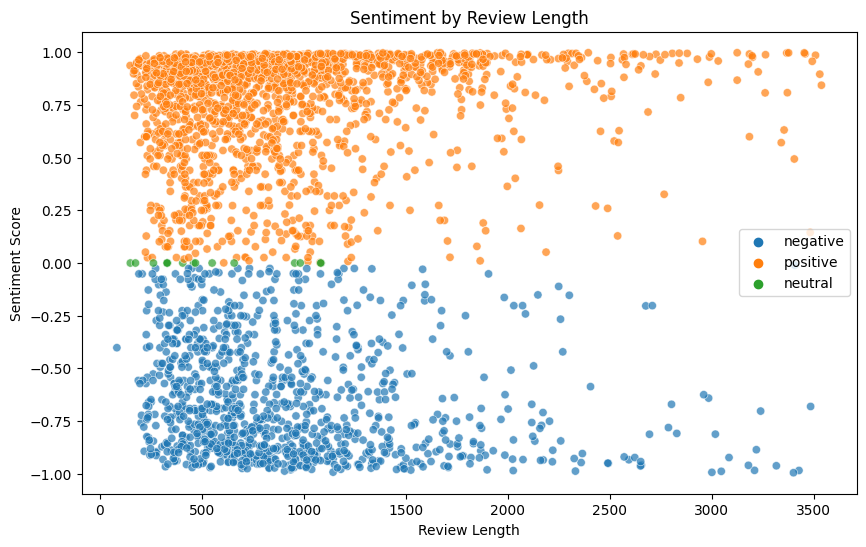

In [20]:
# Calculate review lengths
df['review_length'] = df['reviews'].apply(len)

# Sentiment by Review Length
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='review_length', y='sentiment_score', hue='sentiment', alpha=0.7)
plt.xlabel('Review Length')
plt.ylabel('Sentiment Score')
plt.title('Sentiment by Review Length')
plt.legend()
plt.show()


In [26]:
# Create a new DataFrame with selected columns
selected_columns = [ 'cleaned_reviews','sentiment', 'sentiment_score']
selected_df = df[selected_columns]

# Save the selected DataFrame to a CSV file
selected_file_path = 'data/selected_BA_reviews.csv'
selected_df.to_csv(selected_file_path, index=False)

print(f"Selected columns saved to {selected_file_path}")

Selected columns saved to data/selected_BA_reviews.csv
